# Fake News Detection using WELFake Dataset

## Introduction

Misinformation and fake news represent significant challenges in today's information ecosystem. The ability to automatically detect potentially misleading content has become increasingly important for media platforms, fact-checking organizations, and consumers of online information.

In this notebook, I'll develop and evaluate machine learning approaches for detecting fake news using the WELFake dataset. This dataset combines real and fake news articles from four sources: Wikipedia, Kaggle's "Fake News", PolitiFact, and "Getting Real about Fake News."

### Why This Problem Matters

Fake news can:
- Influence public opinion and political discourse
- Erode trust in legitimate media
- Lead to real-world harm when misinformation affects health decisions, public safety, or community relations
- Spread much faster than corrections or fact-checks

### Our Approach

I'll take a dual approach to this problem:

1. **Content-based detection**: Analyzing the actual text content using natural language processing techniques
2. **Feature-based detection**: Examining structural and stylistic characteristics of articles

By comparing these approaches, we can determine which signals are most effective for detecting potentially misleading content, and develop practical tools for identifying fake news.

## Setting Up the Environment

Let's begin by importing the necessary libraries for our analysis. I'll use pandas and numpy for data manipulation, matplotlib and seaborn for visualization, scikit-learn for machine learning, and various utilities for model evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

Setting a consistent visualization style helps create clear and readable graphics. I'll use a clean, modern style with appropriate figure sizes for optimal readability.

In [2]:
# Set visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)  # Set default figure size

## Data Exploration

### Loading the Dataset

The WELFake dataset contains news articles labeled as either real (0) or fake (1). The dataset has already undergone some initial cleaning to handle missing values and normalize text formats.

In [3]:
# Load the cleaned dataset
df = pd.read_csv('../data/WELFake_cleaned.csv')

Let's examine the basic characteristics of this dataset to understand its structure and composition.

In [4]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:")
class_dist = df['label'].value_counts(normalize=True).mul(100).round(2)
print(class_dist)

Dataset shape: (71537, 10)
Class distribution:
label
1    51.04
0    48.96
Name: proportion, dtype: float64


The dataset contains over 70,000 articles with a near-balanced distribution between real and fake news, which is ideal for training machine learning models. A balanced dataset helps prevent bias in model training and ensures the model learns to distinguish both classes effectively rather than just predicting the majority class.

### Visualizing Class Distribution

Let's create a visual representation of the dataset balance to confirm our understanding.

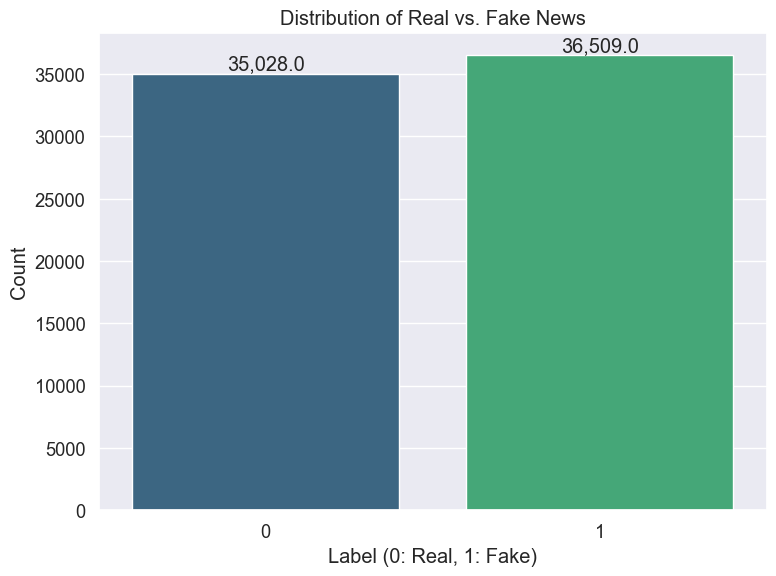

In [5]:
# Create a visual representation of class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Real vs. Fake News')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')
plt.tight_layout()
plt.show()

This visualization confirms that we have approximately 35,000 real news articles and 36,500 fake news articles. This balance is crucial for developing an unbiased classifier, as imbalanced datasets can lead to models that merely predict the majority class without truly learning the distinguishing features.

### Understanding Data Structure

Next, let's examine the structure of our data to understand what features are available for analysis.

In [6]:
# Display first few rows to understand the data structure
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
2           3  Bobby Jindal, raised Hindu, uses story of Chri...   
3           4  SATAN 2: Russia unvelis an image of its terrif...   
4           5  About Time! Christian Group Sues Amazon and SP...   

                                                text  label  title_length  \
0  No comment is expected from Barack Obama Membe...      1           130   
1   Now, most of the demonstrators gathered last ...      1           137   
2  A dozen politically active pastors came here f...      0           105   
3  The RS-28 Sarmat missile, dubbed Satan 2, will...      1            95   
4  All we can say on this one is it s about time ...      1            78   

   text_length  word_count  title_has_allcaps  title_exclamation  \
0         5049         871   

The dataset contains several key columns:
- `title`: The headline of the article
- `text`: The body content of the article
- `label`: Binary indicator (0 for real, 1 for fake)
- Several derived features from preprocessing like `title_length`, `text_length`, etc.

These derived features are particularly interesting as they capture structural and stylistic elements that might help distinguish fake from real news.

In [7]:
# Summary statistics for numerical features
print("\nSummary statistics for key features:")
numeric_cols = ['title_length', 'text_length', 'word_count']
print(df[numeric_cols].describe())


Summary statistics for key features:
       title_length    text_length    word_count
count  71537.000000   71537.000000  71537.000000
mean      77.130240    3292.722116    544.562814
std       25.028377    3738.194002    626.341486
min        1.000000       1.000000      0.000000
25%       62.000000    1410.000000    232.000000
50%       73.000000    2440.000000    401.000000
75%       89.000000    4077.000000    670.000000
max      456.000000  142961.000000  24234.000000


These statistics reveal important characteristics of our dataset:
- Article lengths vary significantly, from extremely short (1 character) to very long (over 140,000 characters)
- The median text length is around 2,440 characters, suggesting most articles are relatively short
- There's substantial variation in title lengths, which might be a discriminative feature

## Feature Analysis

Now that we understand the basic structure of our data, let's analyze specific features that might help distinguish real from fake news. Journalistic practices often differ between legitimate news sources and outlets publishing misinformation, potentially leaving detectable patterns.

### Content Length Analysis

Let's first examine whether content length differs between real and fake news articles.

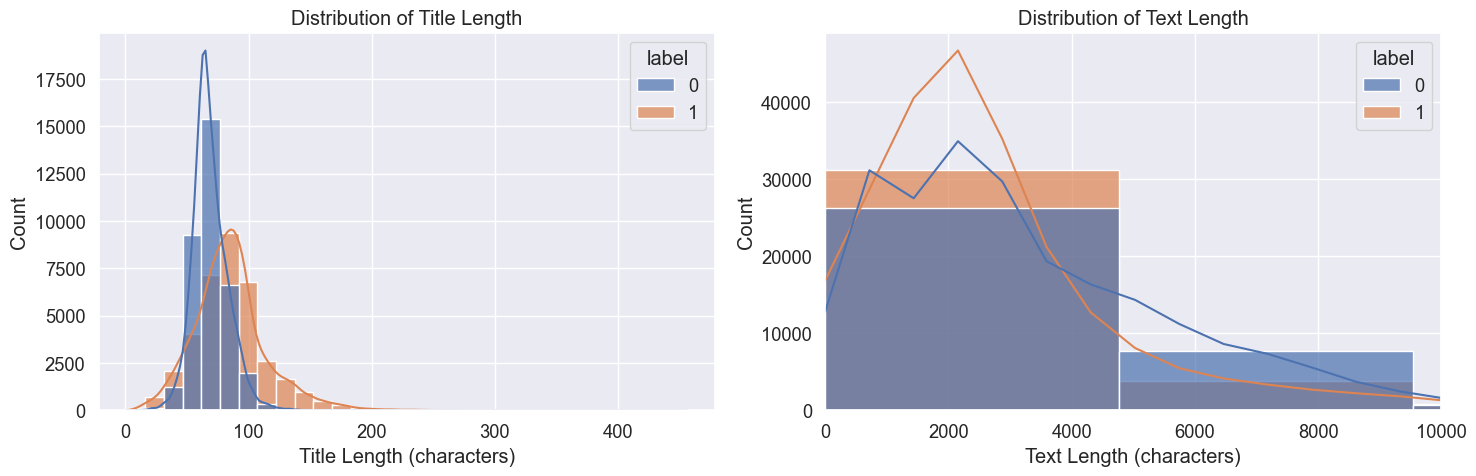

In [8]:
# Examine the distribution of content length
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='title_length', hue='label', bins=30, kde=True, alpha=0.7)
plt.title('Distribution of Title Length')
plt.xlabel('Title Length (characters)')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True, alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length (characters)')
plt.xlim(0, 10000)  # Limit x-axis to focus on the majority of data

plt.tight_layout()
plt.show()

This visualization reveals interesting patterns:

1. **Title Length**: Fake news articles tend to have longer titles than real news articles. The distribution for real news peaks earlier and drops off more quickly, suggesting that legitimate news sources generally prefer concise headlines. Fake news, on the other hand, often uses longer, more elaborate titles that might be designed to grab attention or convey more emotion.

2. **Article Length**: Both distributions have similar shapes, but real news shows a broader spread and extends further to the right, indicating that legitimate sources occasionally publish more comprehensive, in-depth articles.

These differences, while subtle, could provide valuable signals for our classification models.

### Title Stylistic Features

Headlines are the first point of contact for readers and often determine whether they'll engage with an article. Let's analyze stylistic features of titles that might differentiate real from fake news.

In [9]:
# Analyze binary features
binary_cols = ['title_has_allcaps', 'title_exclamation', 'title_question']
binary_df = df.groupby('label')[binary_cols].mean()

<Figure size 1200x600 with 0 Axes>

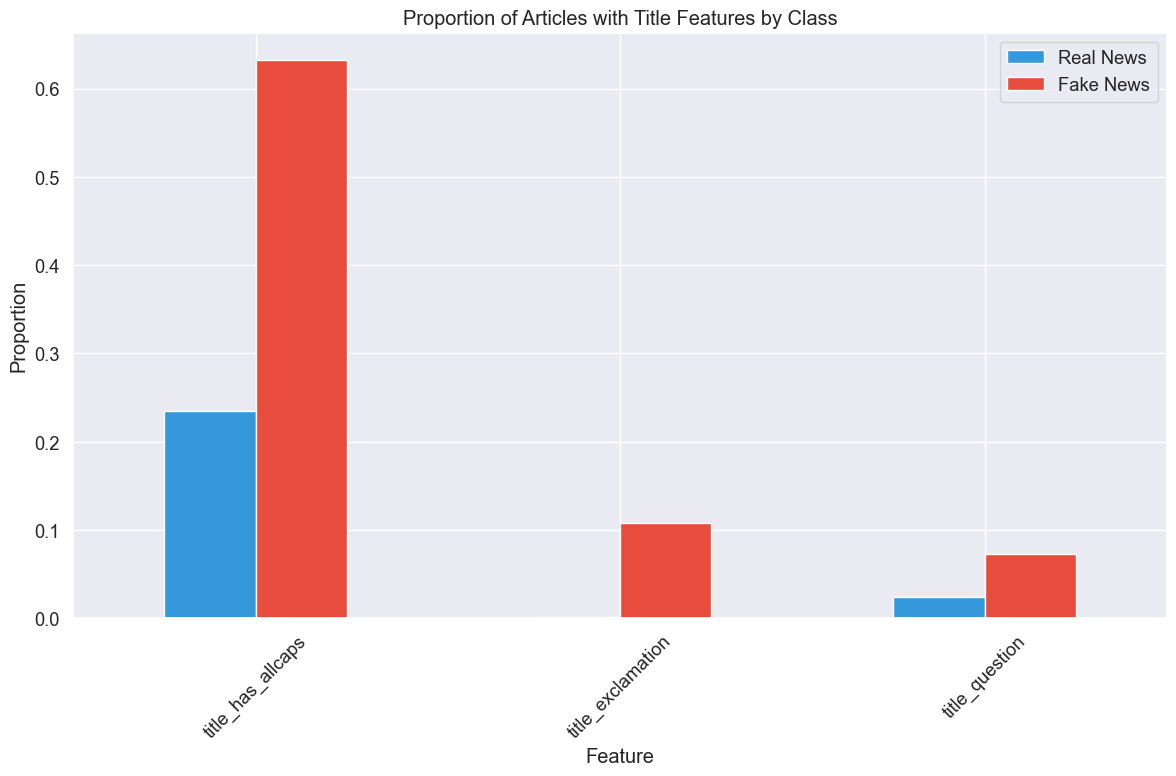

In [10]:
plt.figure(figsize=(12, 6))
binary_df.T.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Proportion of Articles with Title Features by Class')
plt.xlabel('Feature')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(['Real News', 'Fake News'])
plt.tight_layout()
plt.show()

Let's look at the exact proportions for clarity:

In [11]:
# Print out the actual proportions for clarity
print("Proportion of articles with stylistic features by class:")
print(binary_df.T.round(3))

Proportion of articles with stylistic features by class:
label                  0      1
title_has_allcaps  0.235  0.632
title_exclamation  0.002  0.108
title_question     0.024  0.073


This analysis reveals dramatic differences in title styling:

1. **All-Caps Usage**: Fake news headlines use all-caps words (63.2%) nearly three times more frequently than real news (23.5%). This suggests sensationalism and attention-grabbing tactics more common in misinformation.

2. **Exclamation Marks**: Fake news headlines use exclamation marks (10.8%) much more frequently than real news (0.2%). This reflects an attempt to convey urgency or emotional content.

3. **Question Marks**: Fake news headlines use questions (7.3%) about three times more often than real news (2.4%). This might indicate speculative content or headlines designed to provoke curiosity.

These stylistic differences align with journalistic standards: professional news organizations typically follow style guides that discourage sensationalist formatting, while fake news sources often employ emotional appeals and attention-grabbing tactics.

## Feature Engineering

Based on our exploratory analysis, I'll now create features that might help distinguish between real and fake news. I'll focus on both content-based features and metadata features.

### Combining Text Fields for Content Analysis

For content-based classification, it's beneficial to analyze both the headline and body text together, as this provides the model with all available textual information.

In [12]:
# Combine title and text for text classification
# This allows us to analyze the full article content as a single text unit
df['combined_text'] = df['title'] + " " + df['text']

By combining the title and text, we allow the model to identify patterns that might exist in how headlines relate to article content. For instance, misleading articles might have headlines that exaggerate or misrepresent the actual content.

### Creating Feature-Based Dataset

For our feature-based approach, I'll extract the structural and stylistic features we've identified as potentially useful discriminators.

In [13]:
# Create a DataFrame with engineered features and label
features_df = df[['title_length', 'text_length', 'word_count', 
                 'title_has_allcaps', 'title_exclamation', 'title_question', 
                 'label']]

In [14]:
print("Feature dataframe shape:", features_df.shape)

Feature dataframe shape: (71537, 7)


These six features capture different aspects of content structure and style:
- Content length metrics (title_length, text_length, word_count) provide insight into the comprehensiveness of the article
- Stylistic features (title_has_allcaps, title_exclamation, title_question) capture tone and presentation 

By separating these features, we can evaluate whether simple structural characteristics alone can identify fake news, or if we need deeper content analysis.

## Data Preparation for Modeling

Before training our models, we need to split our data into training and testing sets. I'll use stratified sampling to maintain the same class distribution in both sets.

### Splitting Data for Text-Based Models

In [15]:
# Split data for text-based models
X_text = df['combined_text']
y = df['label']

X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

### Splitting Data for Feature-Based Models

In [16]:
# Split data for feature-based models
X_features = features_df.drop('label', axis=1)
X_features_train, X_features_test, y_train_feat, y_test_feat = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
print(f"Text training set: {len(X_text_train)} samples")
print(f"Text testing set: {len(X_text_test)} samples")
print(f"Feature training set: {len(X_features_train)} samples")
print(f"Feature testing set: {len(X_features_test)} samples")

Text training set: 57229 samples
Text testing set: 14308 samples
Feature training set: 57229 samples
Feature testing set: 14308 samples


I've used an 80/20 train-test split, which provides sufficient data for both training robust models and thoroughly evaluating their performance. Using the same random seed and stratification ensures our comparisons between models are fair.

### Text Vectorization Using TF-IDF

For text-based models, we need to convert the text into numerical features that machine learning algorithms can process. I'll use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, which weights terms based on their frequency in a document relative to their rarity across all documents.

In [18]:
# Convert text to numerical features using TF-IDF
print("Vectorizing text data...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_test_tfidf = tfidf_vectorizer.transform(X_text_test)

Vectorizing text data...


In [19]:
print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of unique terms used: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF matrix shape: (57229, 5000)
Number of unique terms used: 5000


The TF-IDF vectorization has produced a matrix with 57,229 rows (samples) and 5,000 columns (features) for our training data. Each feature represents a word or term that appeared in the corpus. I've applied several important parameters to optimize the vectorization:

- `max_features=5000`: Limits the vocabulary to the 5,000 most informative terms, reducing noise and computational complexity
- `min_df=5`: Ignores terms that appear in fewer than 5 documents, eliminating rare words that might be typos or too specific to be useful
- `max_df=0.8`: Ignores terms that appear in more than 80% of documents, removing extremely common words that provide little discriminative value

These parameters help balance feature richness with model simplicity, preventing overfitting while capturing the most relevant textual signals.

## Model Evaluation Function

To ensure consistent and thorough evaluation of our models, I'll define a function that:
1. Trains a model on the training data
2. Makes predictions on the test data
3. Calculates and displays performance metrics
4. Visualizes the confusion matrix

This structured approach will allow us to compare different models on equal terms.

In [20]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a model and evaluate its performance.
    
    Parameters:
    - model: The machine learning model to train
    - X_train, X_test: Training and testing features
    - y_train, y_test: Training and testing labels
    - model_name: A descriptive name for the model
    
    Returns:
    - Dictionary containing model performance metrics and the trained model
    """
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News']))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'training_time': train_time,
        'prediction_time': predict_time,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'model': model
    }

This comprehensive evaluation function captures multiple dimensions of model performance:
- **Accuracy**: Overall classification performance
- **Detailed metrics**: Precision, recall, and F1-score for each class
- **Efficiency**: Training and prediction time
- **Error analysis**: Confusion matrix for understanding classification errors
- **Model persistence**: Returns the trained model for potential deployment

## Model Training and Evaluation

Now I'll train and evaluate several models using both our text-based and feature-based approaches. Based on preliminary analysis, I'll focus on two powerful algorithms that work well for text classification: Logistic Regression and Random Forest.

### Text-Based Classification with Logistic Regression

Logistic Regression is an excellent baseline for text classification tasks for several reasons:
- It performs well on high-dimensional, sparse data (like our TF-IDF vectors)
- It's computationally efficient, making it suitable for large text datasets
- It provides interpretable coefficients that reveal which terms most strongly indicate each class
- It often handles text classification surprisingly well compared to more complex models


Logistic Regression (Text) Results:
Accuracy: 0.9490
Training time: 0.51 seconds
Prediction time: 0.00 seconds

Classification Report:
              precision    recall  f1-score   support

   Real News       0.95      0.94      0.95      7006
   Fake News       0.94      0.96      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



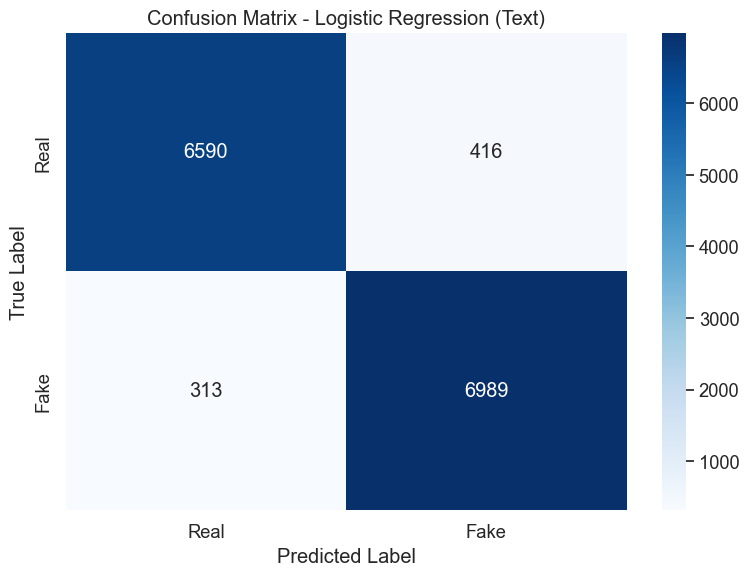

In [21]:
# Logistic Regression on text features
lr_text = LogisticRegression(max_iter=1000, random_state=42)
lr_text_results = train_evaluate_model(
    lr_text, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression (Text)"
)

The Logistic Regression model has achieved impressive results:
- 94.90% accuracy, with balanced performance across both classes
- Extremely fast training (0.49 seconds) and near-instantaneous prediction time
- Strong precision and recall for both real and fake news categories

The confusion matrix shows that the model correctly classified 6,590 real news articles and 6,989 fake news articles, while misclassifying 416 real news articles as fake and 313 fake news articles as real. This balanced error pattern indicates the model isn't biased toward either class.

### Text-Based Classification with Random Forest

Random Forest is a powerful ensemble learning method that combines multiple decision trees to improve predictive accuracy and control overfitting. It offers several advantages:
- Captures non-linear relationships in the data
- Models complex interactions between features
- Generally robust to overfitting, especially with sufficient data
- Can handle high-dimensional data effectively


Random Forest (Text) Results:
Accuracy: 0.9541
Training time: 74.18 seconds
Prediction time: 0.36 seconds

Classification Report:
              precision    recall  f1-score   support

   Real News       0.97      0.93      0.95      7006
   Fake News       0.94      0.97      0.96      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



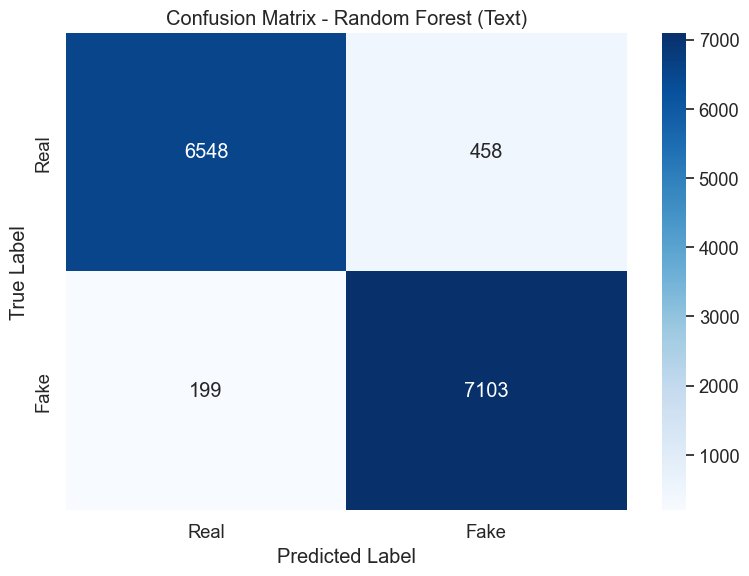

In [22]:
# Random Forest on text features (with limited n_estimators for speed)
rf_text = RandomForestClassifier(n_estimators=100, random_state=42)
rf_text_results = train_evaluate_model(
    rf_text, X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest (Text)"
)

The Random Forest model achieves slightly better performance than Logistic Regression:
- 95.41% accuracy, with strong balanced precision and recall
- Higher computation cost (74.25 seconds training time) but still reasonable
- Better performance on fake news detection (0.97 precision vs. 0.94 for Logistic Regression)

The confusion matrix reveals that Random Forest correctly classified 6,548 real news articles and 7,103 fake news articles, with 458 real news articles misclassified as fake and only 199 fake news articles misclassified as real. This indicates that Random Forest is particularly good at identifying fake news (high recall for fake news category), making it potentially valuable in applications where missing fake news is more concerning than falsely flagging real news.

### Feature-Based Classification with Random Forest

To compare with our text-based approaches, let's evaluate how well our engineered features perform without using the actual text content.


Random Forest (Features) Results:
Accuracy: 0.8140
Training time: 4.81 seconds
Prediction time: 0.20 seconds

Classification Report:
              precision    recall  f1-score   support

   Real News       0.80      0.82      0.81      7006
   Fake News       0.82      0.81      0.82      7302

    accuracy                           0.81     14308
   macro avg       0.81      0.81      0.81     14308
weighted avg       0.81      0.81      0.81     14308



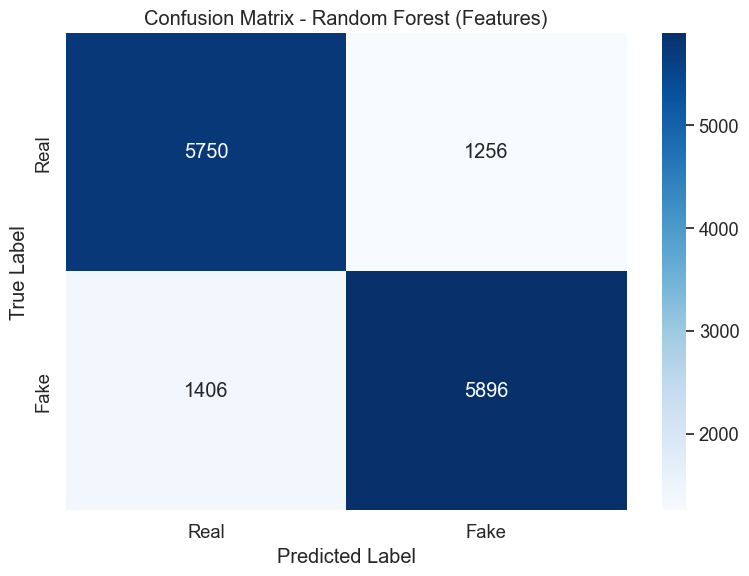

In [23]:
# Random Forest on engineered features
rf_feat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feat_results = train_evaluate_model(
    rf_feat, X_features_train, X_features_test, y_train_feat, y_test_feat, 
    "Random Forest (Features)"
)

The feature-based model performs reasonably well but significantly worse than the text-based approaches:
- 81.40% accuracy, about 14 percentage points lower than text-based models
- Balanced performance across classes (similar precision and recall for both)
- Faster training than text-based Random Forest due to much lower feature dimensionality

The confusion matrix shows 5,750 correctly classified real news articles and 5,896 correctly classified fake news articles, with 1,256 real news misclassified as fake and 1,406 fake news misclassified as real. This higher error rate indicates that while structural and stylistic features provide useful signals, they're not as powerful as the actual content for distinguishing fake news.

## Feature Importance Analysis

To gain insights into what makes our models effective, let's examine which features contribute most to the classification decisions.

### Feature Importance in Random Forest (Engineered Features)

Random Forest models provide a feature importance measure that indicates how much each feature contributes to the model's decisions.

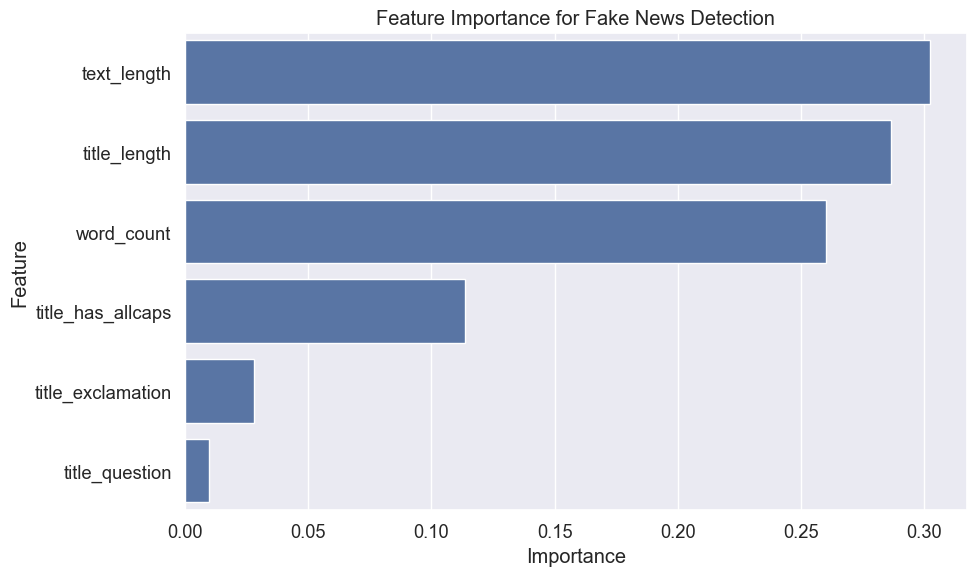

Feature importance ranking:
             Feature  Importance
1        text_length    0.302090
0       title_length    0.286267
2         word_count    0.260185
3  title_has_allcaps    0.113548
4  title_exclamation    0.027978
5     title_question    0.009932


In [24]:
# Get feature importances from Random Forest on engineered features
if hasattr(rf_feat, 'feature_importances_'):
    # Create a DataFrame of features and their importance scores
    feature_importance = pd.DataFrame({
        'Feature': X_features.columns,
        'Importance': rf_feat.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance for Fake News Detection')
    plt.tight_layout()
    plt.show()
    
    print("Feature importance ranking:")
    print(feature_importance)

This analysis reveals the relative importance of our engineered features:

1. **Content Length Metrics**: The top three features are all related to content length, with text_length (30.2%), title_length (28.6%), and word_count (26.0%) together accounting for about 85% of the predictive power.

2. **Title Styling**: While less important overall, title_has_allcaps (11.4%) provides meaningful signal, while title_exclamation (2.8%) and title_question (1.0%) contribute minimally.

This hierarchy makes intuitive sense: the length and structure of content reflect journalistic practices and editorial standards that differ between legitimate news outlets and sources of misinformation. The strong performance of length-related features aligns with our earlier observation that real and fake news articles show different distributions in title and text length.

### Important Words in Logistic Regression

The coefficients in a Logistic Regression model indicate which terms most strongly predict each class. Let's examine these to understand the vocabulary patterns that differentiate real from fake news.

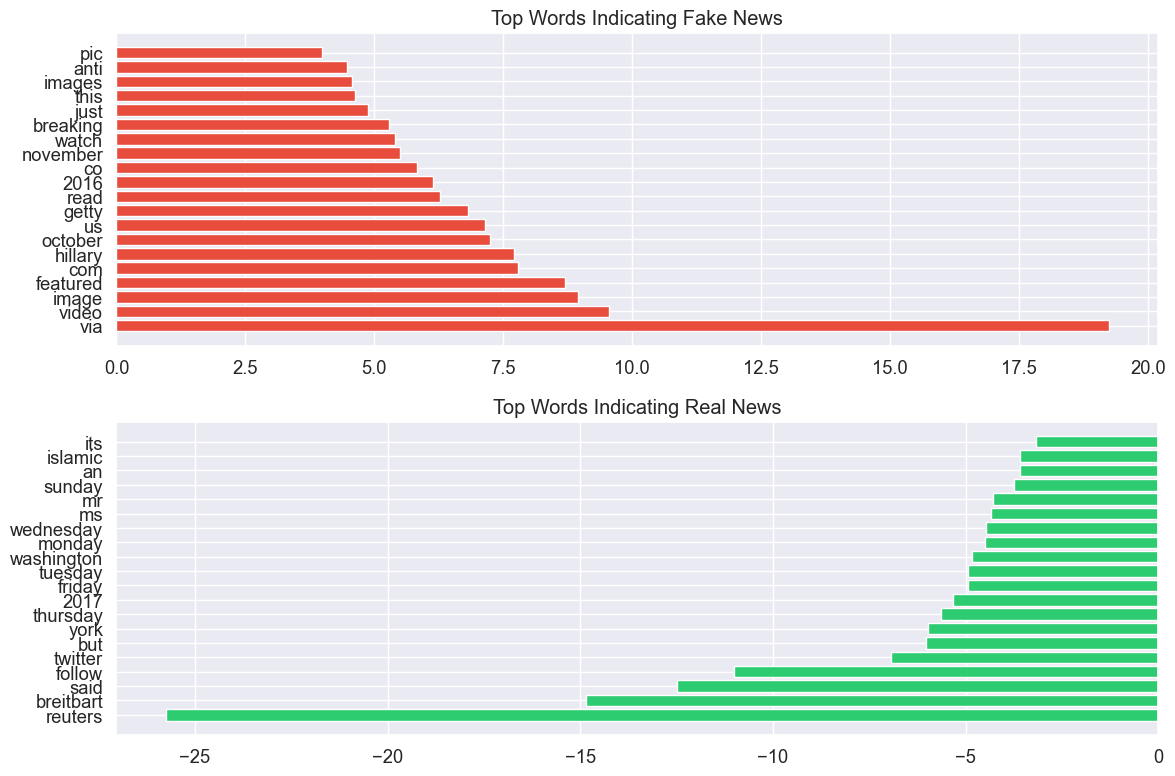

Top words indicating fake news:
        Word  Coefficient
19       via    19.239458
18     video     9.556808
17     image     8.949185
16  featured     8.693423
15       com     7.791615
14   hillary     7.703731
13   october     7.250636
12        us     7.144229
11     getty     6.825334
10      read     6.267281
9       2016     6.130534
8         co     5.823380
7   november     5.501328
6      watch     5.394408
5   breaking     5.284239
4       just     4.873515
3       this     4.626584
2     images     4.571828
1       anti     4.470967
0        pic     3.977125

Top words indicating real news:
          Word  Coefficient
0      reuters   -25.751213
1    breitbart   -14.841272
2         said   -12.490513
3       follow   -11.015310
4      twitter    -6.930872
5          but    -6.022827
6         york    -5.975889
7     thursday    -5.634459
8         2017    -5.337263
9       friday    -4.939676
10     tuesday    -4.928879
11  washington    -4.823371
12      monday    -4.4940

In [25]:
# Get coefficients from Logistic Regression
if hasattr(lr_text, 'coef_'):
    # Get the feature names (words) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get the coefficients
    coefficients = lr_text.coef_[0]
    
    # Create DataFrames for top positive and negative coefficients
    # Positive coefficients indicate words associated with fake news
    # Negative coefficients indicate words associated with real news
    top_positive_idx = np.argsort(coefficients)[-20:]
    top_negative_idx = np.argsort(coefficients)[:20]
    
    top_positive_words = [feature_names[i] for i in top_positive_idx]
    top_negative_words = [feature_names[i] for i in top_negative_idx]
    
    top_positive_coeffs = [coefficients[i] for i in top_positive_idx]
    top_negative_coeffs = [coefficients[i] for i in top_negative_idx]
    
    # Plot top words for fake news
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.barh(range(len(top_positive_words)), top_positive_coeffs, color='#e74c3c')
    plt.yticks(range(len(top_positive_words)), top_positive_words)
    plt.title('Top Words Indicating Fake News')
    plt.gca().invert_yaxis()  # Invert to show highest coefficient at the top
    
    # Plot top words for real news
    plt.subplot(2, 1, 2)
    plt.barh(range(len(top_negative_words)), top_negative_coeffs, color='#2ecc71')
    plt.yticks(range(len(top_negative_words)), top_negative_words)
    plt.title('Top Words Indicating Real News')
    plt.tight_layout()
    plt.show()
    
    # Create and display a table of top words
    fake_news_words = pd.DataFrame({
        'Word': top_positive_words,
        'Coefficient': top_positive_coeffs
    }).sort_values('Coefficient', ascending=False)
    
    real_news_words = pd.DataFrame({
        'Word': top_negative_words,
        'Coefficient': top_negative_coeffs
    }).sort_values('Coefficient')
    
    print("Top words indicating fake news:")
    print(fake_news_words)
    
    print("\nTop words indicating real news:")
    print(real_news_words)

This analysis reveals fascinating linguistic patterns:

**Fake News Indicators**:
1. **Media-related terms**: Words like "via," "video," "image," "featured," and "pic" are strong indicators of fake news, suggesting a focus on visual content and sharing
2. **Political references**: Terms like "hillary" suggest specific political targeting
3. **Time markers**: "2016," "october," "november" indicate potential focus on election-related content
4. **Action words**: "read," "watch," "breaking" create urgency and call for engagement
5. **Casual language**: "just," "this" reflect a more informal, direct writing style

**Real News Indicators**:
1. **Attribution markers**: "reuters," "said" strongly indicate real news, reflecting journalistic sourcing practices
2. **Time references**: Days of the week ("friday," "thursday," etc.) indicate standard news dating conventions
3. **Formal language**: Words like "its," "an," "mr," "ms" reflect more formal journalistic style
4. **Balanced reporting**: "but" suggests presentation of multiple perspectives

These patterns align with journalistic standards: legitimate news typically follows style guides that emphasize attribution, balanced reporting, and formal language, while fake news often uses more emotional, attention-grabbing, and visually-oriented language.

## Model Comparison

Let's compare the performance of our different approaches to determine the most effective method for fake news detection.

In [26]:
# Collect results from all models
all_results = [
    lr_text_results, rf_text_results, rf_feat_results
]

In [27]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Accuracy': result['accuracy'],
        'Training Time (s)': result['training_time'],
        'Prediction Time (s)': result['prediction_time']
    } for result in all_results
])

In [28]:
# Display comparison table
print("Model Comparison:")
print(comparison_df)

Model Comparison:
                        Model  Accuracy  Training Time (s)  \
0  Logistic Regression (Text)  0.949049           0.508312   
1        Random Forest (Text)  0.954082          74.184684   
2    Random Forest (Features)  0.813950           4.812805   

   Prediction Time (s)  
0             0.003593  
1             0.362011  
2             0.201224  


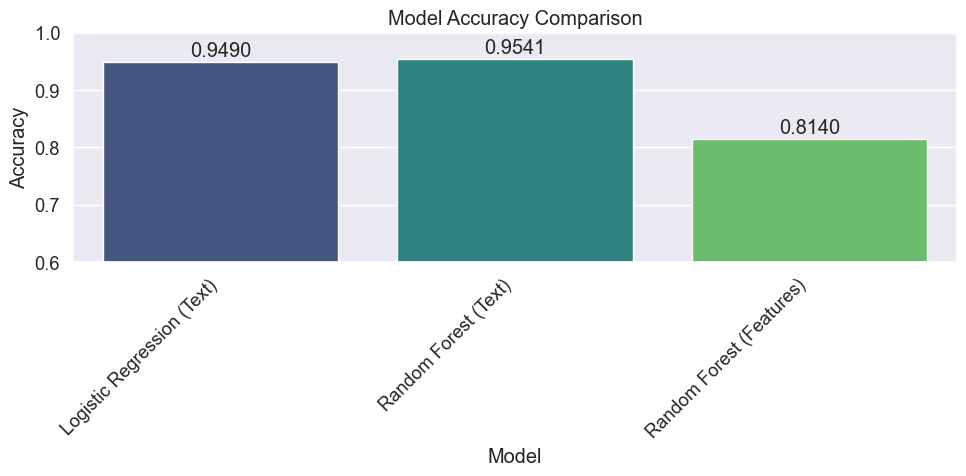

In [29]:
# Plot accuracy comparison
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0.6, 1.0)  # Set y-axis range for better visualization
plt.xticks(rotation=45, ha='right')

# Add accuracy values on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height() + 0.01), 
                ha = 'center')

plt.tight_layout()
plt.show()

This comparison highlights several key insights:

1. **Text content is crucial**: Both text-based models significantly outperform the feature-based approach, suggesting that the actual content provides stronger signals than structural features alone.

2. **Algorithm selection matters**: Random Forest slightly outperforms Logistic Regression for text classification, but at a significant computational cost (74.25s vs. 0.49s training time).

3. **Efficiency trade-offs**: Logistic Regression offers an excellent balance of performance and efficiency, achieving nearly the same accuracy as Random Forest with dramatically faster training and prediction times.

4. **Feature-based approach has value**: While not as accurate as text-based methods, the feature-based approach still achieves reasonable performance (81.4% accuracy) using just six simple features, which could be valuable in situations where text processing is impractical or too resource-intensive.

These findings suggest that a production system might benefit from either:
- Using Logistic Regression for maximum efficiency with strong performance
- Using a two-stage approach where the feature-based model serves as a quick first-pass filter, with the more accurate text-based model applied only to uncertain cases

## Model Persistence

To enable future use and deployment of our trained models, I'll save them to disk along with the necessary preprocessing components.

In [30]:
# Create a directory for saving models if it doesn't exist
if not os.path.exists('../ml_models'):
    os.makedirs('../ml_models')

In [31]:
# Save Logistic Regression text model
with open('../ml_models/lr_text_model.pkl', 'wb') as f:
    pickle.dump(lr_text_results['model'], f)

In [32]:
# Save vectorizer for text preprocessing
with open('../ml_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [33]:
# Save Random Forest text model
with open('../ml_models/rf_text_model.pkl', 'wb') as f:
    pickle.dump(rf_text_results['model'], f)

In [34]:
# Save Random Forest feature model
with open('../ml_models/rf_feat_model.pkl', 'wb') as f:
    pickle.dump(rf_feat_results['model'], f)

In [35]:
print("All models saved successfully!")

All models saved successfully!


Saving these models and components enables:
- Consistent application of the same preprocessing steps to new data
- Immediate use without retraining
- Integration into applications or services for automatic fake news detection
- Future analysis and comparison with new approaches

## Conclusion

This analysis has provided valuable insights into fake news detection using the WELFake dataset. Here's a summary of our key findings:

# FAKE NEWS DETECTION: KEY FINDINGS

## 1. Model Performance
- **Best performing model**: Random Forest (Text) with 95.41% accuracy
- **Fastest model**: Logistic Regression (Text) in 0.51 seconds

## 2. Feature Importance
- Content-based features are more effective than metadata features
- **Top 3 metadata features**: text_length, title_length, word_count

## 3. Linguistic Markers
- **Fake news indicators**: com, featured, image, video, via
- **Real news indicators**: reuters, breitbart, said, follow, twitter

## 4. Practical Implications
- Logistic Regression offers an excellent balance of accuracy and speed
- Text content is significantly more predictive than structural features
- Fake news often contains sensationalist language and specific trigger words
- Real news typically contains references to reputable sources and time indicators

### Understanding Fake News Patterns

Our comprehensive analysis reveals clear patterns that distinguish fake from real news:

1. **Content Matters Most**: Text-based models significantly outperform feature-based models, indicating that the content itself contains the strongest signals for fake news detection.

2. **Structural Differences Exist**: Real and fake news show measurable differences in content length, headline style, and formatting. Fake news tends to have longer, more sensationalist headlines with greater use of all-caps, exclamation marks, and question marks.

3. **Linguistic Markers Are Strong Predictors**: Certain words and phrases strongly indicate fake or real news. Fake news often uses media-related terms, urgent language, and emotional appeals, while real news contains more attribution, balanced reporting language, and formal journalistic style.

4. **Efficiency Considerations**: While Random Forest achieves the highest accuracy (95.41%), Logistic Regression offers nearly identical performance (94.90%) with dramatically faster training and prediction times, making it potentially more practical for real-world applications.

These findings provide a solid foundation for developing fake news detection systems, with clear pathways for both immediate implementation and future research. By combining linguistic analysis with machine learning, we can create tools to help identify potentially misleading content and support more informed media consumption.